# Shopee Code League 6: Sentiment Analysis
### Data Science
Given product reviews, build a model to correctly predict user ratings (1 to 5) for the review

[link to kaggle](https://www.kaggle.com/c/shopee-sentiment-analysis/overview)

# 1 Introduction
This is Shopee competition, where the task in this competition is to build a multiple product review sentiment classificaiton model. There are about 150k product reviews form different categories, including elecgtronics, furniture, home & living products like air-conditioner and fashion products like T-shirts, rings etc. 

The evaluation metrics is top-1 accuracy.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## nlp
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## emoji
import emoji  # https://pypi.org/project/emoji/ (install package: pip install emoji --upgrade)

## spacy
import spacy
## scattertext
import scattertext as st

## sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import classification_report, confusion_matrix

## keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dropout, Dense, SpatialDropout1D, BatchNormalization
from keras.layers import Activation, LSTM
from keras.layers.embeddings import Embedding

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# 2 Data Wrangling

## 2.1 General Properties
- There are total of 146811 reviews with no missing value in train dataset.
- There are total of 60427 reviews in test dataset. 
- Majority of review in **train** dataset is good review (~ 28% each for rating 4 and 5).
- Review rating 2 is with least, about 8.65% only

In [2]:
# Load the data and view the first 5 rows
df = pd.read_csv('./data/train.csv')  #train.csv
test = pd.read_csv('./data/test.csv') #test.csv

print("train: {}".format(df.shape))
print("test: {}".format(test.shape))

df.head()

train: (146811, 3)
test: (60427, 2)


review_id                                             review  rating
0          0  Ga disappointed neat products .. Meletot Hilsn...       1
1          1    Rdtanya replace broken glass, broken chargernya       1
2          2  Nyesel bngt dsni shopping antecedent photo mes...       1
3          3      Sent a light blue suit goods ga want a refund       1
4          4  Pendants came with dents and scratches on its ...       1

In [3]:
# No null value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146811 entries, 0 to 146810
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  146811 non-null  int64 
 1   review     146811 non-null  object
 2   rating     146811 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [4]:
# distribution of the rating in dataset
df.rating.value_counts(normalize=True)

4    0.285163
5    0.282779
3    0.244811
1    0.100708
2    0.086540
Name: rating, dtype: float64

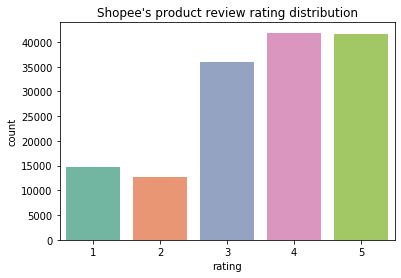

In [5]:
# Visualise the distribution of rating
ax = sns.countplot(x="rating", data = df, palette="Set2")
ax.set_title("Shopee's product review rating distribution");

## 2.2 Text data preprocessing

Sneak peak on the reviews:

In [6]:
# review with rating =1
df.query('rating==1')['review'][100]

'Very misleading label on the product. It says case for Iphone 6 6s plus but they only have 6s plus by the way. Lol fix your labeling so everybody can understand it because it’s the first thing that customers read, not the details below it. Plus the seller is not accommodating.\xa0 Wrong item received'

In [10]:
# review with rating =5
df.query('rating==5')['review'][105298]

'The product price is good. Delivery speed is good. Good product quality. TQ '

### Data manupulation

#### Review's length (word count) 
- On average, length of review for all rating is about 14 words, except rating 1, which has slightly more word (18 words).
- There are exceptional long review (over hundres word) for each category, but rare.

In [212]:
# create another column to count the number of word per reveiw
df['word_count'] = df['review'].str.split().str.len()

In [213]:
df.query('word_count>40')

review_id                                             review  rating  \
2               2  Nyesel bngt dsni shopping antecedent photo mes...       1   
7               7  Shop fraudulent business. we put two lamps, on...       1   
13             13  KALO RULES DO NOT WANT TO PARTICIPATE IN CHAT ...       1   
21             21  He bought out the company Takyah ni.dah la nak...       1   
70             70  I order 1/5. 13/5 seller post. Br 18/5 can ret...       1   
...           ...                                                ...     ...   
146723     146723  Waist 34, hips 45, 171 High belly swollen hock...       5   
146727     146727  The seller was very helpful and replied fast. ...       5   
146763     146763  Wrong size. Large did you send, but still I re...       5   
146766     146766  Orders are, survived until the goal. , , , 😍 😍...       5   
146779     146779  Quite heavy for a headset can't always put int...       5   

        word_count  
2               50  
7               52  
13              45  
21              54  
70              53  
...            ...  
146723          44  
146727          43  
146763          43  
146766          55  
146779          53  

[6265 rows x 4 columns]

In [162]:
6265/df.shape[0]*100

4.267391408000763

In [12]:
round(df.groupby('rating')['word_count'].mean(),2)

rating
1    17.94
2    14.89
3    14.39
4    14.25
5    14.20
Name: word_count, dtype: float64

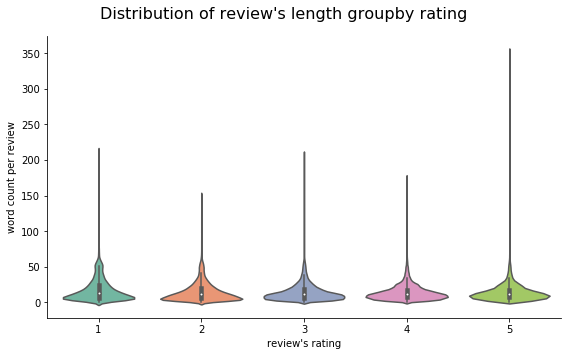

In [13]:
# Visualize the distribution of review's length
ax = sns.catplot(x = "rating", y = "word_count", data = df, palette = "Set2",
                 kind = "violin", height = 5, aspect = 1.6)
ax.fig.subplots_adjust(top = .9)
ax.fig.suptitle("Distribution of review's length groupby rating", fontsize=16)
ax.set_axis_labels("review's rating", "word count per review");

#### Emoji
There are emoji in some of the review (train: 13.7%, test: 12.6%), which, will convert them to text using `.demojize()`, instead of deleting them in text cleaning.

In [14]:
# Get all the row index that has emoji in their review
train_emoji_idx = []
test_emoji_idx = []

for idx, review in enumerate(df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        train_emoji_idx.append(idx)
        
for idx, review in enumerate(test['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        test_emoji_idx.append(idx)

In [15]:
print("Train: {}/{}, {}% has emoji".format(len(train_emoji_idx),df.shape[0], 
                       round(100*len(train_emoji_idx)/df.shape[0],2)))
print("Test: {}/{}, {}% has emoji".format(len(test_emoji_idx),test.shape[0], 
                       round(100*len(test_emoji_idx)/test.shape[0],2)))

Train: 20048/146811, 13.66% has emoji
Test: 7582/60427, 12.55% has emoji


In [16]:
# Peak on review with emoji
df.loc[train_emoji_idx]['review'][-80:-60]

146334    The product price is very murahhhh, suitable f...
146340    Super-fast shipping! And to complete the packa...
146343                                    Beautiful very 💕💕
146344                           In accordance with hrga. 💜
146345     Good product quality Good value for money Exc...
146348    the goods have come, thank kasih😘😘😘😘 equivalen...
146349    Thank you seller of the beautiful colors come ...
146350    The package apology late afternoon until TDI g...
146354    Realpict appropriate pictures, material y jga ...
146355    Very fast delivery COD Chat fastrespon, always...
146360                                       Thank you 😉👌💕💕
146361     Excellent quality Very accommodating seller W...
146362    Still fresh skali ... trims ya..entar message ...
146363    Fast delivery and good service. The price are ...
146364    Recommended seller. Good response, stocks are ...
146372                   StickyNotes dapet funny. makasiih💛
146378    Goods to order. Thank God my c

In [17]:
# change emoji to text using .demojize()
def emoji2text(text):
    """
    Change emoji to text, and replace the ':' in front of emoji text with white space
    """
    return emoji.demojize(text).replace(':'," ")

In [18]:
# Try the emoji2text function
print("Original review:\n", df.loc[146800]['review'])
print("\nReview with emoji2text:\n", emoji2text(df.loc[146800]['review']))

Original review:
 Hehe thanks Baguuuuuuuuuuuus kaaaa😍😍😍😍😍😍😍😍👍👍👍👍👍👍👍👍👍👍👍

Review with emoji2text:
 Hehe thanks Baguuuuuuuuuuuus kaaaa smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up 


#### Repeated characters
There are many malay word with extended ending, like the one shown above **Baguuuuuuuuuuuus**.   
Below is the function to remove such repeated characters.

In [19]:
def trim_repeated_char(text):
    """
    trim repeated characters (>= 3 times) in word
    """
    return re.sub(r'(\w)\1{2,}', r'\1', text)

In [20]:
# try the trim_repeated_char function
trim_repeated_char(emoji2text(df.loc[146800]['review']))

'Hehe thanks Bagus ka smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up  thumbs_up '

### Clean the review's text by the following step:

- change to lowercase
- convert emoji, emoticon to text
- remove punctuations (non-letters, non digit characters)
- trim repeated character
- tokenize the review,
- remove short words (length <=2)
- lemmatize each word of the text,
- remove stopwords (malay)
- remove strange or unwanted words

Once completed, convert back to string text.

In [214]:
def clean_text(text):
    """
    Input: string of text
    Function for text cleaning by converting them into lowercase, emoji to text
    remove punctuations, trim repeated character
    tokenize to word, lemmatize each word, remove stopwords and customize less meaningful words
    Output: sting of text after the text cleaning
    remove 
    """
    
    # Instantiate object of class WordNetLemmatizer
    lemm = WordNetLemmatizer()
    
    # 1. convert all text to lowercase
    lower = text.lower()
    
    # 2. change emoji to text
    lower = emoji2text(lower)
    
    # 3. change emoticon to text
    lower = re.sub(r':\(','dislike', lower)
    lower = re.sub(r':\(\(','dislike', lower)
    lower = re.sub(r':, \(','dislike', lower)
    lower = re.sub(r':\)','smile', lower)
    lower = re.sub(r';\)','smile', lower)
    lower = re.sub(r':\)\)\)','smile', lower)
    lower = re.sub(r':\)\)\)\)\)\)','smile', lower)
    lower = re.sub(r'=\)\)\)\)','smile', lower)
    lower = re.sub(r'♡', 'love', lower)
    
    # 4. change ok to okay and tq to thankyou (to avoid to be removed due to short word in step8)
    lower = re.sub(r'ok','okay', lower)
    lower = re.sub(r'(okay)[a-z]*', 'okay', lower)  #trim words after okay
    lower = re.sub(r'tq','thankyou', lower)
    
    # 5. retain letter, digit and space only (remove all punctuation, symbols)
    letters_only = re.sub("[^a-zA-Z0-9\s]","", lower)
    
    # 6. trim the repeated character
    letters_only = trim_repeated_char(letters_only)
    
    # 7. tokenize string (split into words, use tokenizer instead of using .split())
    tokens = nltk.tokenize.word_tokenize(letters_only)
    
    # 8. remove very short word, which is mostly not informative
    words = [t for t in tokens if len(t) > 2]
    
    # 9. lemmatize each word
    lemmed_words = [lemm.lemmatize(i) for i in words]
    
    # 10. remove stopwords
    #stops_en_malay = stopwords.words(['english','indonesian'])
    stops_malay = stopwords.words('indonesian')
    # less meaningful word that would like to remove
    noinfo_word = ['bgt', 'kak', 'shopee', 'udh', 'deh', 'lah','dah', 'yaa','tpi',
                   'aja','cuman','pesen','sdh','klo','mksh','krn','wa',
                  'ha','haha', 'hehehe', 'mah', 'nya', 'yah', 'pa', 'si', 'le',
                  'msh','nih','cea', 'ttp','huhu', 'krna', 'tau', 'kaka','lgi',
                  'gak','pc','sya','yung','gan']
    # combine stop words & less meaningful word
    #stops_en_malay.extend(noinfo_word)
    stops_malay.extend(noinfo_word)
    #stops = set(stops_en_malay)
    stops = set(stops_malay)
    
    meaningful_words = [w for w in lemmed_words if w not in stops]
    
    # 11. join back to string
    return (" ".join(meaningful_words))

Code cell below is to clean the review's text using `clean_text()` function defined above.

In [215]:
# Get the number of documents based on the df's size
print(f"There are {df.shape[0]} documents in the dataset")

# Initiate empty list to hold the clean's review
clean_review = []
test_clean_review = []

# clean and parsing the review's content
print("Cleaning and parsing the train dataset review's content in df['review']:")

i = 0
for review_content in df.review:
    # clean the text using clean_text(raw_review) function
    clean_review.append(clean_text(review_content))
    
    # if the index is divisible by 10000, print a message
    if (i+1) % 10000 == 0:
        print(f"Document {i+1} of {df.shape[0]}")
    i +=1

# clean and parsing the review's content
print("Cleaning and parsing the test dataset review's content in test['review']:")

j = 0
for review_content in test.review:
    test_clean_review.append(clean_text(review_content))
    
    if (j+1) % 10000 == 0:
        print(f"test {j+1} of {test.shape[0]}")
    j += 1

There are 146811 documents in the dataset
Cleaning and parsing the train dataset review's content in df['review']:
Document 10000 of 146811
Document 20000 of 146811
Document 30000 of 146811
Document 40000 of 146811
Document 50000 of 146811
Document 60000 of 146811
Document 70000 of 146811
Document 80000 of 146811
Document 90000 of 146811
Document 100000 of 146811
Document 110000 of 146811
Document 120000 of 146811
Document 130000 of 146811
Document 140000 of 146811
Cleaning and parsing the test dataset review's content in test['review']:
test 10000 of 60427
test 20000 of 60427
test 30000 of 60427
test 40000 of 60427
test 50000 of 60427
test 60000 of 60427


In [216]:
# Create another column with clean review, asides drop reivew_id as it does not add any informative
df.drop('review_id', axis=1, inplace=True)
df['clean_review'] = clean_review
test['clean_review'] = test_clean_review

In [217]:
# Export clean text to csv
# 3 is stopwords with malay only
df.to_csv('./data/train_clean3.csv', index = False)
test.to_csv('./data/test_clean3.csv', index = False)

# 3 Exploratory Data Analysis

## 3.1 Sentiment scores
Using `Vader` from **NLTK** module to calculate the sentiment scores based on the *clean_review*. Vader's `SentimentIntensityAnalyzer()` takes in a string and returns a dictionary of scores in each of four categories:
- negative
- neutral
- positive
- compound (computed by normalizing the scores above).

I will use it to calculate the sentiment scores to get a rough feel on how's the rating correlated with the sentiment scores based on the *clean_review*.

From the visualisation plot, **all category of rating** have almost the same range of compund's score (negative to positive values). Expected to be challenging in predicitng the user's rating based on the review's text. However, the **mean compound's score** is **increasing** with increasing rating.

**Mean compound's score** of **rating 4 & 5** are very **close to each other**, which could make the user' rating prediction on these 2 groups difficuilt.

In [5]:
df = pd.read_csv('./data/train_clean3.csv')
test = pd.read_csv('./data/test_clean3.csv')

In [6]:
# There are 52 rows with NaN after clean text on the review's content in train dataset
df.isnull().sum()

review           0
rating           0
word_count       0
clean_review    54
dtype: int64

In [7]:
# There are 14 rows with NaN after clean text on the review's content in train dataset
test.isnull().sum()

review_id        0
review           0
clean_review    14
dtype: int64

Review became NaN after text cleaning in **train** dataset

In [10]:
df[df.isnull()['clean_review']]

review  rating  word_count  \
3388                                             32 to 36       1           3   
7576                                           Less 3 pcs       1           3   
10409   กล่อง มี รอย เปิด ส่ง ช้า มาก Dddddddddddddddd...       1           8   
11748   พอใช้พอใช้ddddd ddddddddddddddddddddd ddddd dd...       1           9   
12384   Hhh hhh hhh hhh hhh hhh hhh hhh hhh hhh hhh hh...       1          53   
14493                                    PM 32 yg to 28,        1           5   
15215   AAAAAAAAAAAAAAAAAAAAAA BBBBBBBBBBBBBBBBBBBBBB ...       2           5   
16621   B a g u s b a g u s b a g u s b a g u s b a g ...       2         150   
18503                                          Mksh ya ..       2           3   
18950   .................................................       2           3   
19601                                       It so so ya,        2           4   
20186   B a g u s ssssssssssssssssssssssssssssssssssss...       2           6   
32089   Yyyyyyyyyyy Yyyyyyyyyyy Yyyyyyyyyyy Yyyyyyyyyy...       3           5   
32138   Llllllllll Uuuuuuuuuu Mmmmmmmmmm Aaaaaaaaaa Yy...       3           7   
35796   ............. ............ ............ .........       3           5   
36718   ........          .......... ..   ...  . .    ...       3           7   
37813   Yaaaaaaaaaaaaaaaaaaaaaaa yaaaaaaaaaaaaaaaaaaaa...       3           2   
40530   Dddddddddddddddddddddddddddddddddddddddddddddd...       3           8   
40656   🖒🖒🖒🖒🖒    🖒🖒🖒🖒🖒    🖒🖒🖒🖒🖒    🖒🖒🖒🖒🖒    🖒🖒🖒🖒🖒    🖒...       3          10   
40839   .....................     .......................       3           2   
42707   .................................................       3           2   
43229   ............................................ ....       3           2   
46237                                         Mksh sis ..       3           3   
48754   .................................................       3           5   
52291   ....................................    ..  .....       3           3   
54803                      Sampaiiiiiiiiiiiiiiiiiiiiii jg       3           2   
58595   It ..............................................       3           5   
60442   Oooooooooooooooooooooooooooooooooo Kkkkkkkkkkk...       3           2   
63703   讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚...       4          27   
63704   Ty ty ty ty ty ty ty ty ty ty ty ty ty ty tyýy...       4          15   
65715   讚 讚讚 讚讚 讚 讚讚 讚讚 讚讚 讚讚 讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚讚 讚 讚讚...       4          55   
66956                                    Hi Hi Hi Hi Hi V       4           6   
68043   ........... .......... .......... .......... ....       4          12   
69303                                           5 deh ...       4           3   
70750                                  <3 <3 <3 <3 <3 <3        4           6   
76587                      𝐆𝐚𝐧𝐝𝐚 𝐧𝐢𝐲𝐚 𝐧𝐠𝐮𝐬𝐭𝐮𝐡𝐚𝐧 𝐧𝐠 𝐛𝐛𝐲 𝐤𝐨       4           6   
80574   B b b b b b b b b b b b b b b b b b b v v n n ...       4          71   
84836                                     Mksh kak ya ...       4           4   
86268   𝘛𝘦𝘳𝘪𝘮𝘢𝘬𝘢𝘴𝘪𝘩 𝘱𝘢𝘬𝘦𝘵 𝘮𝘦𝘯𝘥𝘢𝘳𝘢𝘵 𝘥𝘦𝘯𝘨𝘢𝘯 𝘴𝘦𝘭𝘢𝘮𝘢𝘵, 𝘴𝘢𝘺...       4          13   
87503   สินค้า Ddddddddddddddddddddddddddddddddddddddd...       4           6   
89962                                        Mksh gan ...       4           3   
98468   =============•============== •••••••••••••••••...       4           2   
100903  DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...       4           2   
109417                                  T o p b a n g e t       5           9   
109651  Ddddddddddddd Ddddddddddddd​Ddddddddddddd​Dddd...       5           2   
109724  Bbbbbbbbbbbb ÁÁÁÁÁÁÁÁÁÁÁÁÁÁÁÁ gggggggggggggg u...       5           5   
110441  Ốpppppppppppppppppppppp đepppppppppppppppppppp...       5           2   
115066  .................................................       5           2   
115172  My my my my my my my my my my my my my my my m...       5          33   
1

Review became NaN after text cleaning in **test** dataset

In [222]:
test[test.isnull()['clean_review']]

review_id                                             review  \
296          297  (￣︶￣)> <(￣︶￣)/ (‵﹏′) ╮(‵▽′)╭(￣︶￣)> <(￣︶￣)/ (‵﹏...   
2778        2779  K u a l i t a s  p r o d u k  b a i k\nP r o d...   
4186        4187  ...................... ................. ........   
7767        7768  sɛʀʋɨs s rɢ t ʟʍɮt 3 ʍɨrɢɢʊ ɮʀ ɖk t. t t r tɨҡ...   
10407      10408  siiii ..................................... .....   
11754      11755  คุณภาพ ดี ส่ง เร็ว\nDddddd Dddddd Dddddd Ddddd...   
13806      13807  ......................................... .......   
21498      21499     .                                            .   
34930      34931  Ssssuuuuuuudddddddddaaaaaaaaahhhhhhhhhhh sssss...   
35839      35840  wwwwwwwwwwwwwwwww\ndddddddddddddddd\nfffffffff...   
43655      43656  ........................................... . ...   
50747      50748  .................................................   
52643      52644  Mmmmmmmmmmmmmmmm mmmmmmmmm mmmmmmmmmm mmmmmmmm...   
55801      55802  DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD DDDDDDDDDDDD...   

      clean_review  
296            NaN  
2778           NaN  
4186           NaN  
7767           NaN  
10407          NaN  
11754          NaN  
13806          NaN  
21498          NaN  
34930          NaN  
35839          NaN  
43655          NaN  
50747          NaN  
52643          NaN  
55801          NaN

In [11]:
# drop train data with NaN after cleaning as most of the review does not have 
# meaningful content
df.dropna(axis=0, inplace=True)

# fill NaN with white space for test dataset
test.fillna(' ', inplace=True)

#### Vader sentiment scores

In [180]:
# Instantiate 
sid = SentimentIntensityAnalyzer()

# create new columns for sentiment scores and extract the compound scores from it
df['scores'] = df['clean_review'].apply(lambda x: sid.polarity_scores(x))
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])

In [181]:
df.head(2)

review  rating  word_count  \
0  Ga disappointed neat products .. Meletot Hilsn...       1          12   
1    Rdtanya replace broken glass, broken chargernya       1           6   

                                        clean_review  \
0  disappointed neat product meletot hilsnyaa spe...   
1     rdtanya replace brokay glass brokay chargernya   

                                              scores  compound  
0  {'neg': 0.221, 'neu': 0.357, 'pos': 0.421, 'co...    0.4215  
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000

In [182]:
# mean compound scores groupby rating
round(df.groupby('rating')['compound'].mean(),3)

rating
1    0.003
2    0.209
3    0.480
4    0.619
5    0.621
Name: compound, dtype: float64

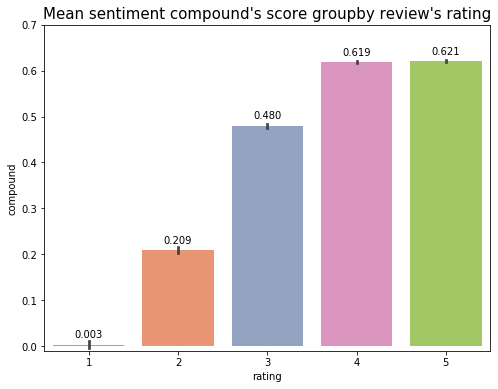

In [184]:
# Visualize the mean compound score
from numpy import mean
plt.figure(figsize=(8,6))
ax = sns.barplot(x="rating", y="compound", data=df, estimator = mean, palette="Set2")
ax.set_ylim(-.01,0.7)
ax.set_title("Mean sentiment compound's score groupby review's rating", fontsize=15);

# add the mean value for each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() /2., p.get_height() ), 
               ha = 'center', va='center', xytext = (0,10), textcoords = 'offset points')

**Visualise** the distribution of compound's score versus review's rating

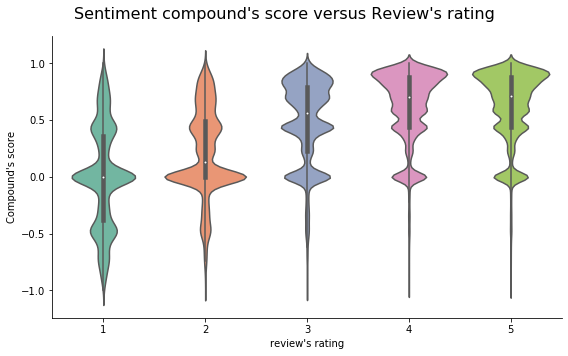

In [185]:
# Visualize the relationship between the Sentiment polarity and rating
ax = sns.catplot(x = "rating", y = "compound", data = df, palette = "Set2",
                 kind = "violin", height = 5, aspect = 1.6)

ax.fig.subplots_adjust(top = .9)
ax.fig.suptitle("Sentiment compound's score versus Review's rating", fontsize=16)
ax.set_axis_labels("review's rating", "Compound's score");

Sentiment Polarity versus Review's Rating


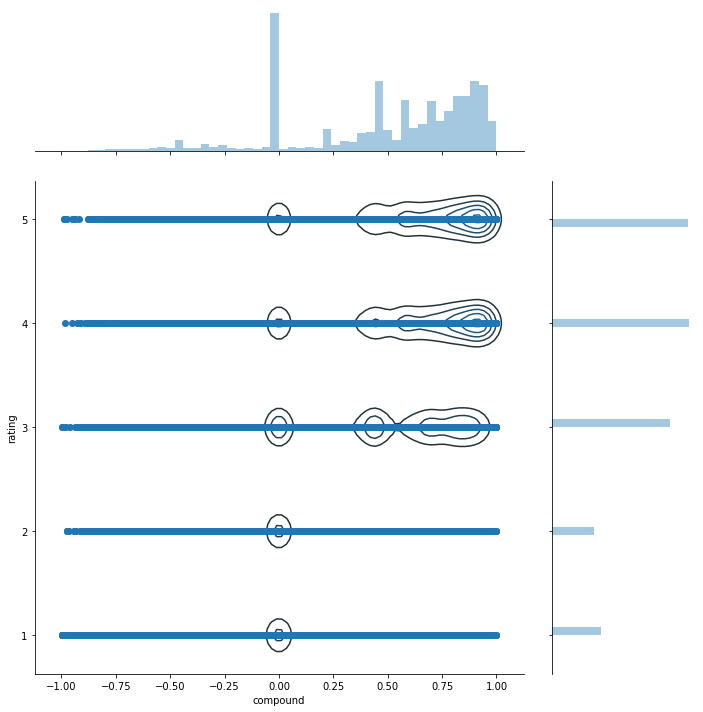

In [34]:
#Visualize using jointplot
ax = (sns.jointplot("compound", "rating", data=df, height = 10, ratio=3)).plot_joint(
        sns.kdeplot, zorder = 0, n_levels = 6)

print("Sentiment Polarity versus Review's Rating")

## 3.2 Correlations among numeric variables
Calculate the correlation coefficient of `rating`, `word_count` of the review as well as the calculated `compound` scores.

- `rating` and `compound` score is in *positive correlation*.
- `compound` and `word_count` is having *weak positive correlation*. Indicating trend of having more words on good review, which is actually contradicting with the *weak negative correlation* between `rating` and `word_count`.

In [186]:
corr = df[['rating','word_count','compound']].corr()
corr

rating  word_count  compound
rating      1.000000   -0.072552  0.459612
word_count -0.072552    1.000000  0.137012
compound    0.459612    0.137012  1.000000

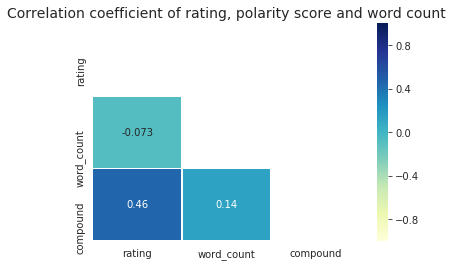

In [187]:
# visualise using heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize = (6,4))
    ax = sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, annot = True,
                     linewidths=.5, cmap = 'YlGnBu')
    ax.set_title("Correlation coefficient of rating, polarity score and word count", fontsize=14)
    

## 3.3 Frequent word
- view the frequent words for each rating using WordCloud

In [188]:
#Wordcloud function
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
                background_color = "white",
                colormap='tab20b',
                max_words = 500,
                max_font_size = 40,
                scale = 2,
                random_state = 42,
                ).generate(str(data.values))
    
    fig = plt.figure(1, figsize = (10,6))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 18)
        fig.subplots_adjust(top = 1)
    
    plt.imshow(wordcloud)
    plt.show()

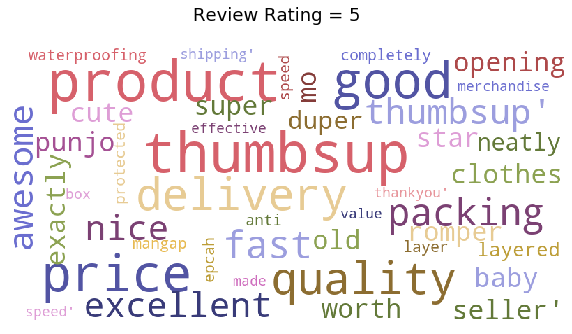

In [189]:
show_wordcloud(df.query('rating == 5')['clean_review'], "Review Rating = 5")

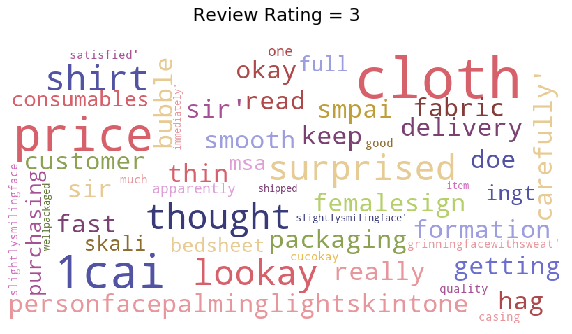

In [190]:
show_wordcloud(df.query('rating == 3')['clean_review'], "Review Rating = 3")

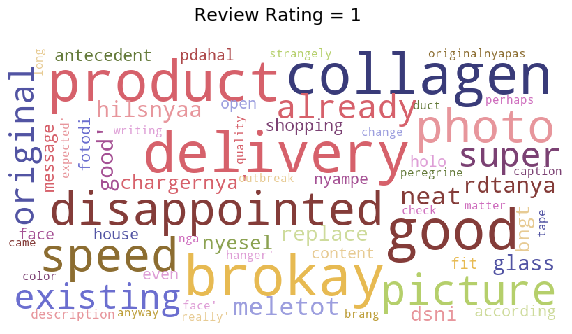

In [191]:
show_wordcloud(df.query('rating == 1')['clean_review'], "Review Rating = 1")

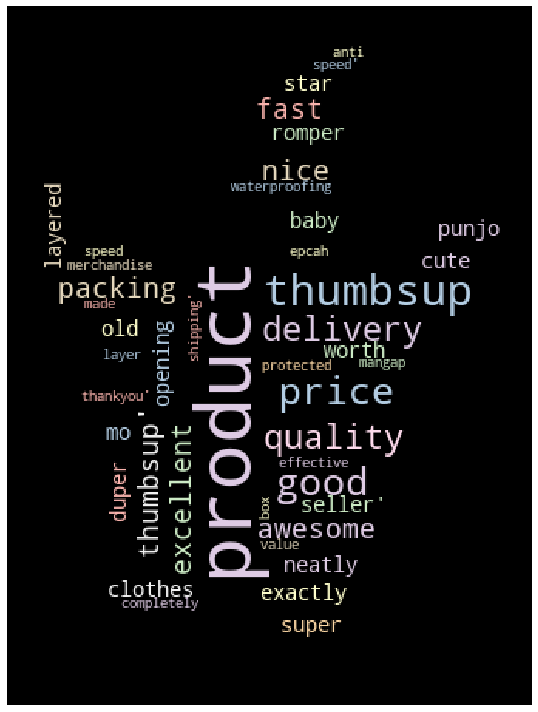

In [192]:
# try to add in mask for review with rating =5, just for fun
from PIL import Image

# Load image
mask = np.array(Image.open('./image/Patrick_Star.png'))
data = df.query('rating == 5')['clean_review']
wordcloud = WordCloud(background_color='black', max_font_size=50, 
                      colormap='Pastel1', mask=mask).generate(str(data.values))

fig = plt.figure(1, figsize=(8,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()
plt.show()

## 3.4 Finding characteristic terms that associate with the ratings

In [247]:
# Load pretrained model with general english language
nlp = spacy.load("en_core_web_sm")

In [250]:
# Creates a Corpus from a pandas data frame.  
# A Corpus is a Term Document Matrix preserves the original texts.
# Following are the terms that differentiate the review text from a general English corpus.

corpus = st.CorpusFromPandas(df, category_col="rating", text_col = "clean_review",
                            nlp = nlp).build()

print(list(corpus.get_scaled_f_scores_vs_background().index[:30]))

['thumbsup', 'smilingfacewithhearteyes', 'smilingfacewithsmilingeyes', 'redheart', 'thumbsuplightskintone', 'faceblowingakiss', 'beamingfacewithsmilingeyes', 'okhand', 'foldedhands', 'cepet', 'grinningface', 'awesome', 'twohearts', 'huggingface', 'whitemediumstar', 'smilingface', 'loudlycryingface', 'lookay', 'alhamdulillah', 'grinningfacewithsmilingeyes', 'thumbsupmediumlightskintone', 'okay', 'brokay', 'bagus', 'wellpackaged', 'heartsuit', 'thankyou', 'accommodating', 'starstruck', 'banget']


**gpp** stands for gak pak pak, which means it's okay

In [251]:
# Following are the terms in review that are mostly associated with each rating.

rating_list = list(set(df.rating))
term_freq_df = corpus.get_term_freq_df()

for rating in rating_list:
    col_name = 'rating_' + str(rating)
    term_freq_df[col_name] = corpus.get_scaled_f_scores(rating)
    print(f"Term mostly associated with : rating of {rating}")
    print("--------------------------------------------------------")
    print(list(term_freq_df.sort_values(by = col_name, ascending = False).index[:30]))
    print("\n\n")
    

Term mostly associated with : rating of 1
--------------------------------------------------------
['thumbsdownlightskintone thumbsdownlightskintone', 'service poor', 'thumbsdownlightskintone', 'damaged defective', 'very poor', 'angryface angryface', 'bad service', 'defective item', 'poor product', 'poutingface poutingface', 'poutingface', 'item different', 'bad bad', 'angryface', 'from picture', 'terrible', 'receive item', 'time below', 'wrong item', 'pileofpoo', 'bad quality', 'very disappointed', 'not receive', 'below expectation', 'not original', 'not order', 'pileofpoo pileofpoo', 'poor service', 'not working', 'quality poor']



Term mostly associated with : rating of 2
--------------------------------------------------------
['quality fair', 'standard seller', 'quality temporary', 'anxiousfacewithsweat', 'fair value', 'quality standard', 'time expected', 'anxiousfacewithsweat anxiousfacewithsweat', 'smilingfacewithhorns smilingfacewithhorns', 'standard product', 'general merchan

# 4 Pre-processing
- Create X-feature and y-target(i.e.: rating) for modelling
- Train test split
- Class-weights

In [12]:
# Create X-feature and y-target (label)
X = list(df['clean_review'])  #train dataset
Xtest = list(test['clean_review'])   #test dataset

#label, convert to rating from 0 to 4, as we'll need to change to_categorical
y = df['rating']-1 

### Train test spit

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y,
                                                   shuffle = True, random_state = 42)

### Class weights for imbalance dataset

In [14]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

print(f"class weights: {class_weights}")
print(f"class.       : {np.unique(y_train)}")

class weights: [1.98604415 2.31134954 0.81701461 0.70134409 0.70719513]
class.       : [0 1 2 3 4]


In [15]:
# change int categorical in y to dummies
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f"y_train: {y_train.shape}")

y_train: (117405, 5)


# 5 Modeling

## 5.1 Baseline
Calculate the percentage distribution for each class, i.e. the rating from the reviewer

In [197]:
df.rating.value_counts(normalize=True)

4    0.285191
5    0.282839
3    0.244792
1    0.100670
2    0.086509
Name: rating, dtype: float64

## 5.2 Recurrent Neural Network (LSTM)
Recurrent neural network is a type of neural networks that is proven to work well with sequence data. Since text is a sequence of words, I try to solve this sentiment classification problems with LSTM (Long Short Term Memory network), which is a variant of RNN, and compared to results from other classifier (Logistic, Naive Bayes, SVM), which I done in a separate notebook.

### 5.2.1 Preparing the Embedding layer
Use `Tokenizer` class from the `keras.preprocessing.text` module to create a **word-to-index** dictionary. Each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key. 

In [16]:
max_features = 12500  # This is selected as it is roughly the range of optimized hyperparameter used in other classifier in another notebook

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
Xtest = tokenizer.texts_to_sequences(Xtest)

In [17]:
# peak on the index for each vocab (words in corpus)
tokenizer.index_word

{1: 'good',
 2: 'the',
 3: 'product',
 4: 'quality',
 5: 'very',
 6: 'delivery',
 7: 'thumbsup',
 8: 'seller',
 9: 'and',
 10: 'price',
 11: 'not',
 12: 'speed',
 13: 'excellent',
 14: 'but',
 15: 'awesome',
 16: 'fast',
 17: 'smilingfacewithhearteyes',
 18: 'for',
 19: 'okay',
 20: 'order',
 21: 'value',
 22: 'response',
 23: 'nice',
 24: 'you',
 25: 'thank',
 26: 'smilingfacewithsmilingeyes',
 27: 'redheart',
 28: 'thanks',
 29: 'service',
 30: 'that',
 31: 'with',
 32: 'it',
 33: 'like',
 34: 'this',
 35: 'time',
 36: 'original',
 37: 'also',
 38: 'other',
 39: 'item',
 40: 'well',
 41: 'again',
 42: 'money',
 43: 'will',
 44: 'really',
 45: 'shop',
 46: 'packaging',
 47: 'color',
 48: 'thumbsuplightskintone',
 49: 'are',
 50: 'buy',
 51: 'his',
 52: 'just',
 53: 'faceblowingakiss',
 54: 'material',
 55: 'ship',
 56: 'received',
 57: 'size',
 58: 'all',
 59: 'have',
 60: 'already',
 61: 'shipping',
 62: 'can',
 63: 'packing',
 64: 'there',
 65: 'too',
 66: 'from',
 67: 'long',
 68: 

The X_train, X_test, and Xtest are now are list of *integer*, which the actual word is the corresponding *value* in the dictionary shown above.   
Code cell below list its corresponding word from one of the list

In [19]:
# For example, can check out the sequence and its corresponding word
for i in X_train[30]:
    print(f"{i}: {tokenizer.index_word[i]}")

244: see
37: also
281: sale
1272: instant
50: buy
373: set
16: fast
6: delivery
46: packaging
203: certainly


**Padding**    
Set maximum size of each list (i.e. length of each document) to 35.    
In exploratory analysis, the average mean of reivew's length is 14-17 words. Review with more than 35 words only made up of about 6% of the train dataset. Thus, I chose 35 as the max size. 

In below code cell, list with size greater than 35 will be truncated to 35. For those less than 35 will add 0 at the end of the list untill it reaches length of 35.

In [75]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 50  # 6% of review is >35 words

X_train = pad_sequences(X_train, padding='post', maxlen = maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen = maxlen)
Xtest = pad_sequences(Xtest, padding = 'post', maxlen = maxlen)

In [76]:
print(f" Corpus is now has {vocab_size} unique words")

 Corpus is now has 51826 unique words


In [77]:
X_train.shape

(117405, 50)

### Create the LSTM Network
- embed_dim, lstm_out/ neurons, dropout values are all hyperparameter that can be tuned for better results

In [80]:
embed_dim = 64
neurons_1 = 64*2
neurons_2 = 64 #64

model = Sequential()
# Turns positive integers into dense vectors of fixed size
# This layer can only be used as the first layer in a model
embedding_layer = Embedding(input_dim = vocab_size, output_dim = embed_dim, 
                            input_length=X_train.shape[1])
model.add(embedding_layer)
model.add(SpatialDropout1D(0.5))

# neurons (lstm_out) is typically multiple of the embed_dim
model.add(LSTM(neurons_1, dropout=0.5, recurrent_dropout=0.5))
#model.add(LSTM(neurons_1, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#model.add(LSTM(neurons_2, dropout=0.5))

# output layer, softmax is used as this is using categorical crossentropy
model.add(Dense(5, activation='softmax'))

# add optimizer
#Ad = optimizers.Adam(learning_rate = 0.001)

# model compilation
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 64)            3316864   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 50, 64)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 645       
Total params: 3,416,325
Trainable params: 3,416,325
Non-trainable params: 0
_________________________________________________________________
None


### Fit model

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs =12, verbose =2,
                    validation_data = (X_test, y_test), class_weight=class_weights)

Train on 117405 samples, validate on 29352 samples
Epoch 1/12
 - 200s - loss: 1.5063 - accuracy: 0.2831 - val_loss: 1.5027 - val_accuracy: 0.2828
Epoch 2/12
 - 198s - loss: 1.5038 - accuracy: 0.2826 - val_loss: 1.5036 - val_accuracy: 0.2828
Epoch 3/12
 - 197s - loss: 1.5034 - accuracy: 0.2838 - val_loss: 1.5026 - val_accuracy: 0.2828
Epoch 4/12


# 6 Model Evaluation

### Loss and accuracy score of train & validation data

In [37]:
### Define Loss and Accuracy plot function
def loss_acc_plot(historyname, epochs_num, title):
    """
    Input: history, number of epochs, and title of the plot
    This function plot the loss and accuracy curve of both the train & validation data
    of each epochs
    """
    fig, (ax1,ax2) = plt.subplots(nrows = 2, sharex = True, figsize=(12,10));
    # Loss plot
    ax1.plot(historyname.history['loss'], 'r', label = 'Train Loss')
    ax1.plot(historyname.history['val_loss'], 'b', label = 'Test Loss')
    ax1.legend(loc =1)
    ax1.set_ylabel('Crossentropy Loss', fontsize = 14)
    ax1.set_ylim(0,3)
    ax1.set_title(title +" "+ 'Loss Curve', fontsize = 18)
    
    # Accuracy plot
    ax2.plot(historyname.history['accuracy'], 'r', label = 'Train Accuracy')
    ax2.plot(historyname.history['val_accuracy'], 'b', label = 'Test Accuracy')
    ax2.legend(loc =2)
    ax2.set_ylabel('Accuracy', fontsize =14)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylim(0,1)
    plt.xlabel('Epochs', fontsize = 14)
    plt.xticks(np.arange(0,epochs_num+1,10))
    ax2.set_title(title +" " +'Accuracy Curve', fontsize =18)
    

To evaluate the performance of the model, can pass the test set to the `.evaluate()` method

In [38]:
### Function to evaluate the model by calculating the loss and accuracy score
def xtest_loss_acc(modelname, X_test, y_test):
    """
    Input: model, X_test, y_test
    This function evaluate the model and print the loss and accuracy score
    """
    
    model_score = modelname.evaluate(X_test, y_test, verbose =2)
    model_labels = modelname.metrics_names
    
    print(f"LSTM {model_labels[0]}: {round(model_score[0] ,3)}")
    print(f"LSTM {model_labels[1]}: {round(model_score[1] ,3)}")

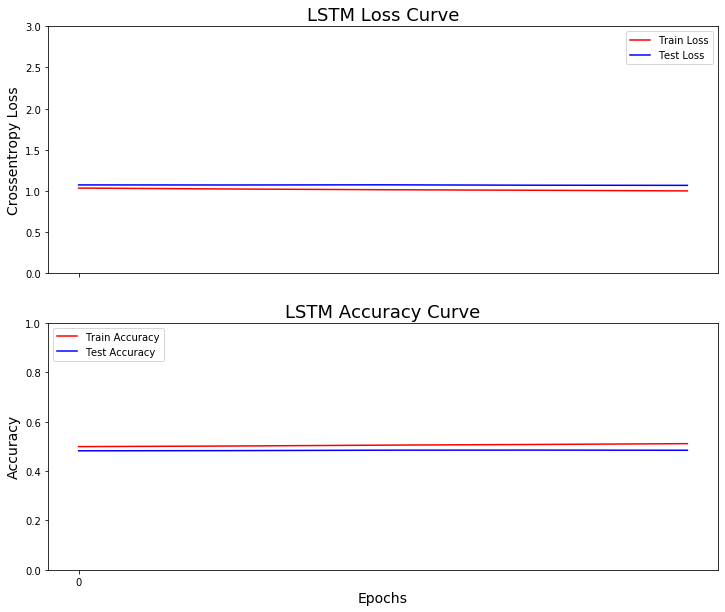

In [58]:
### Plot Loss & Accuracy curve
loss_acc_plot(history, 5, 'LSTM')

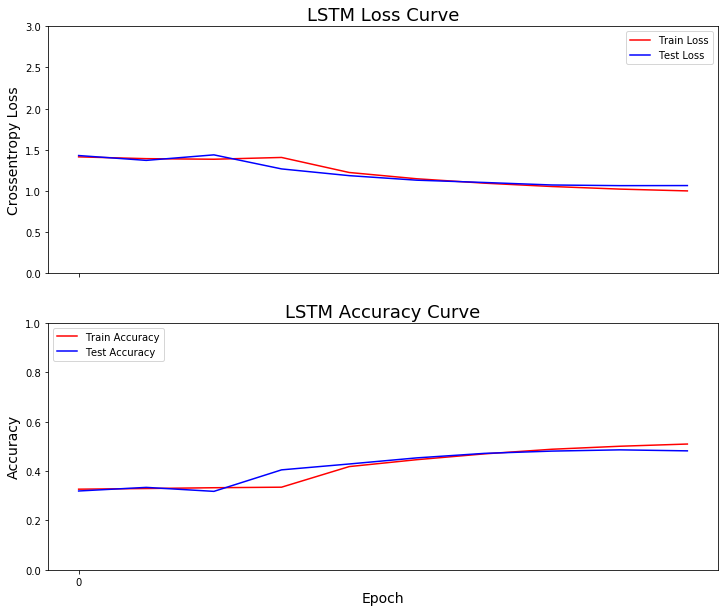

In [257]:
### Plot Loss & Accuracy curve
loss_acc_plot(history, 12, 'LSTM')

In [59]:
xtest_loss_acc(model, X_test, y_test)

LSTM loss: 1.068
LSTM accuracy: 0.484


In [258]:
xtest_loss_acc(model, X_test, y_test)

LSTM loss: 1.065
LSTM accuracy: 0.481


### Classification report and confusion matrix

In [42]:
def class_report(modelname, X_test, y_test):
    """
    Input: model, X_test, y_test
    This function use the model to predict the rating form X_test (ypred)
    print the classification based on y_test (i.e. y_true) and ypred
    and return y_true, and ypred
    """
    
    ### predict the X_test
    ypred = modelname.predict_classes(X_test)+1. #rating start from 1 to 5
    
    y_true = [np.argmax(y)+1 for y in y_test]
    
    print(classification_report(y_true, ypred))
    return y_true, ypred

In [43]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Input: confusion_matrix, classes (or the y-label)
    This function plots the confusion matrix.
    """
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

    plt.show()

In [44]:
def conf_matrix_pct(cm):
    
    """
    Input: confusion matrix
    This function print out the confusion matrix and
    call the plot_confusion_matrix() function to 
    plot the cm in percentage, diagonal is the recall for each classes
    """
    # convert to percentage and plot the confusion matrix
    cm_pct = cm.astype(float) / cm.sum(axis = 1)[:,np.newaxis]
    
    classes = set(y_true)
    print("Confusion matrix:")
    print(cm)
    plot_confusion_matrix(cm_pct, classes)

In [60]:
y_true, ypred = class_report(model, X_test, y_test)

              precision    recall  f1-score   support

           1       0.60      0.71      0.65      2956
           2       0.48      0.29      0.36      2540
           3       0.54      0.62      0.58      7185
           4       0.38      0.26      0.30      8370
           5       0.46      0.57      0.51      8301

    accuracy                           0.48     29352
   macro avg       0.49      0.49      0.48     29352
weighted avg       0.47      0.48      0.47     29352



In [242]:
#submission 3
y_true, ypred = class_report(model, X_test, y_test)

              precision    recall  f1-score   support

           1       0.61      0.69      0.64      2957
           2       0.44      0.29      0.35      2541
           3       0.55      0.59      0.57      7189
           4       0.44      0.21      0.28      8373
           5       0.42      0.65      0.51      8303

    accuracy                           0.48     29363
   macro avg       0.49      0.48      0.47     29363
weighted avg       0.48      0.48      0.46     29363



Confusion matrix:
[[2112  260  447   86   51]
 [ 641  744  899  167   89]
 [ 467  412 4467 1153  686]
 [ 157   64 1213 2139 4797]
 [ 149   61 1203 2150 4738]]


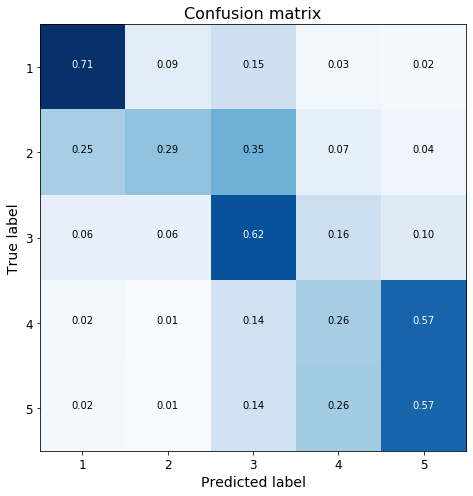

In [61]:
conf_matrix_pct(confusion_matrix(y_true, ypred))

Confusion matrix:
[[2031  297  443   90   96]
 [ 612  725  901  101  202]
 [ 432  424 4263  379 1691]
 [ 135  101 1088 1725 5324]
 [ 134   95 1063 1652 5359]]


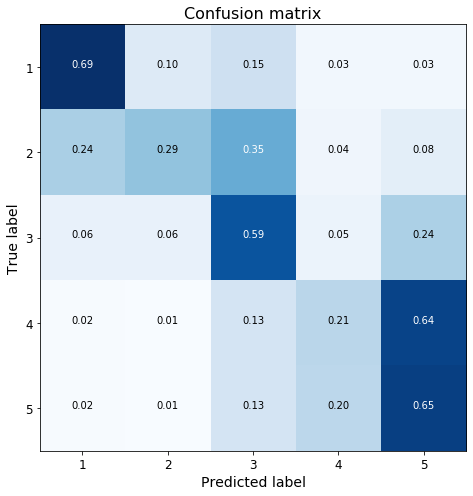

In [248]:
#submission 3
conf_matrix_pct(confusion_matrix(y_true, ypred))

## Predict test dataset 

In [62]:
testpred = model.predict_classes(Xtest)+1

In [63]:
test['rating'] = testpred
test.head()

review_id                                             review  \
0          1  Great danger, cool, motif and cantik2 jg model...   
1          2                   One of the shades don't fit well   
2          3                                   Very comfortable   
3          4  Fast delivery. Product expiry is on Dec 2022. ...   
4          5  it's sooooo cute! i like playing with the glit...   

                                        clean_review  rating  
0  great danger cool motif and cantik2 model deli...       4  
1                        one the shade dont fit well       3  
2                                   very comfortable       4  
3  fast delivery product expiry dec 2022 product ...       5  
4  it cute like playing with the glitter better t...       4

In [64]:
# 1st submission, score: 0.36409
# 2nd submission using LogisticRegression, socre: 0.36784
# 3rd submission using LSTM, score: 0.39
# 4th submission using LSTM (stopwords on malay only), score = 0.3
test[['review_id','rating']].to_csv('./data/submission6.csv', index = False)

# References
1. [Text Processing, Augmentation, TPU baseline 0.4544](https://www.kaggle.com/indralin/text-processing-augmentation-tpu-baseline-0-4544)
2. [LSTM Sentiment Analysis | Keras](https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras)
3. [Python for NLP: Movie Sentiment Analysis using Deep Learning in Keras](https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/)
4. [Imbalanced Data : How to handle Imbalanced Classification Problems](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/)